DESCRIPTION: This notebook enables on-demand visualisation that adapts the visualised data granularity accordign to the zoom level of the view. For smoothThe notebook requires connection with a time-series database 


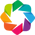

In [1]:
#load with this parameters
#jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

import holoviews as hv
import param, paramnb
import pandas as pd
from colorcet import cm #pip install colorcet
from holoviews.streams import RangeXY, RangeX
import numpy as np
from bokeh.models import HoverTool

import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

import time, os

os.environ['TZ'] = 'UTC'
time.tzset()

#https://stackoverflow.com/questions/41675041/bokeh-time-series-plot-annotation-is-off-by-1-hour/41698735
#https://github.com/bokeh/bokeh/issues/5499
#https://github.com/bokeh/bokeh/issues/1135
#https://github.com/bokeh/bokeh/issues/729
#https://github.com/bokeh/bokeh/issues/1103



from holoviews.operation.timeseries import rolling, rolling_outlier_std

hv.notebook_extension('bokeh', width=100)

from ricercando import set_connection_params, all_tables, all_nodes, getdf, tables_for_node, nodes_for_table
set_connection_params(host='192.168.27.75')
#set_connection_params(host='localhost')


rtt_opts= {'Points':{'style':dict(cmap='Set3', size=2), 'plot':dict( color_index='Message', width=1400, height=400, colorbar=True, tools=['hover']) }}
spikes_colors = {'Scheduling.Task.Started':'green', 'Scheduling.Task.Stopped':'red', 'Scheduling.Task.Deploying':'orange', 'Scheduling.Task.Deployed':'blues'}
spike_opts={'Spikes':{'style':dict( line_width=2, color=hv.Palette('Set3')) }}



sec_res = np.timedelta64(2*60,'m')
min_res = np.timedelta64(1*24*60,'m')
day_res = np.timedelta64(3*24*60,'m')


#data type, if df doesnt coontain these valuse, fill them with appropriate NA values => 'None' if categorical, zero if continous
values = {}
categorical = ['NodeId','EventType', 'Message', 'Host', 'Operator', 'Iccid', 'CID', 'DeviceMode', 'DeviceState', 'Frequency', 'IP_Address', 'Interface', 'MCC_MNC', ]
continous = ['Altitude', 'Latitude', 'Longitude', 'SatelliteCount', 'Speed', 'RTT', 'BootCounter', 'CPU_Apps', 'CPU_User', 'CumUptime', 'Swap',  
             'Uptime', 'ECIO', 'RSRQ','RSSI', 'Temperature']

for val in categorical:
    values[val]='None'
    
for val in continous:
    values[val]=0

#all tables from dataframe
tables = 'ping gps modem event sensor'
    
    
'''
Altitude           float64
Latitude           float64
Longitude          float64
SatelliteCount     float64
Speed              float64
NodeId            category
EventType         category
Message           category
Host              category
Operator          category
RTT                float64
Iccid             category
BootCounter        float64
CPU_Apps           float64
CPU_User           float64
CumUptime          float64
Swap               float64
Uptime             float64
bat_usb0           float64
bat_usb1           float64
bat_usb2           float64
CID               category
DeviceMode        category
DeviceState       category
ECIO               float64
Frequency         category
IP_Address        category
Interface         category
MCC_MNC           category
RSRQ               float64
RSSI               float64
'''



#hv needs fixed number of overlays, layouts at zoom level... when spikes are empty nothing is shown. Lets workaround this by creating dummy spikes on center of x_range with length 0
def dummy_spikes(x_range:None, Day, Month, Year):
    if x_range is None:
        center = (np.datetime64('{0}-{1}-{2} 00:00:00'.format(Year, Month, Day)))+np.timedelta64(12*60,'m')
    else:
        center = (x_range[1]-x_range[0])/2+x_range[0]
    ds = hv.Dataset(( [center, center,center,center], ['Scheduling.Task.Started', 'Scheduling.Task.Stopped', 'Scheduling.Task.Deploying', 'Scheduling.Task.Deployed'] ), kdims=['Date', 'EventType'])
    spike_opts['Spikes']['plot']=dict(spike_length=0)
         
    return ds.to(hv.Spikes).overlay().opts(spike_opts)

def load_data(x_range, Node, Day, Month, Year, Coloring, Colormap, Y='RTT', **kwargs):
    if x_range is not None:

        t_delta = (x_range[1]-x_range[0])
        if t_delta<=sec_res: #we can show 6h of data in 1s resolution with no slowdown
            freq='1s'
        elif t_delta<=min_res: #1 day
            freq='1m'
        else:
            freq='30m'
            
        df = getdf(tables, nodeid=Node, start_time=x_range[0] , end_time=x_range[1], freq=freq)
        events = getdf('event', nodeid=Node, start_time=x_range[0], end_time=x_range[1], freq='10ms')       


        
    else:
        df = getdf(tables, nodeid=Node, start_time='{0}-{1}-{2} 00:00:00'.format(Year, Month, Day), end_time='{0}-{1}-{2} 23:59:59'.format(Year, Month, Day), freq='1m', limit=200000)
        events = getdf('event', nodeid=Node, start_time='{0}-{1}-{2} 00:00:00'.format(Year, Month, Day), end_time='{0}-{1}-{2} 23:59:59'.format(Year, Month, Day), freq='10ms')
        



    #we must return something
    if df.empty:
        return    hv.Layout([hv.Points(pd.DataFrame(columns=['Date',Y]), kdims=['Date', Y],vdims=[]).opts(rtt_opts)  ]).cols(1)
    df['Date'] =  df.index.to_datetime()

    iccids = sorted(df.Iccid.unique().dropna().sort_values())

    for val in categorical: #categorical data have nan and can't be shown if nan is not set to some new categirical value=>'None'
        if val in df.columns:
            df[val] =df[val].cat.add_categories("None")
        else: df[val] = np.nan

    for val in continous:
        if val not in df.columns:
            df[val] = np.nan

    #replace categorical nans with 'None' so it can be shown on plot, else error occurs => float to string exception
    #replace continous nans with zeroes because
    df=df.fillna(value=values)


    rtt_opts['Points']['plot']['color_index']=Coloring

    rtt_opts['Points']['style']['cmap']=Colormap

    table = [ hv.Points(df[df.Iccid==iccid], kdims=['Date', Y], vdims=categorical+continous, label=iccid).opts(rtt_opts ) for iccid in iccids]

    if not events.empty and 'EventType' in events.columns:
        events=events[events['EventType'].str.contains('Scheduling')]
        if not events.empty:
            events['Date'] = events.index.to_datetime()
            ds = hv.Dataset((events.Date, events.EventType), kdims=['Date', 'EventType'])
                    
            max = df[Y].max()
            min = df[Y].min()
            length= abs(max-min)
            
            spike_opts['Spikes']['plot']=dict(spike_length=length, position=min)            
            overlay = ds.to(hv.Spikes).overlay().opts(spike_opts)
            table = [(plot*overlay).relabel(iccid) for plot,iccid in zip(table,iccids)]    
             

        else:
            overlay = dummy_spikes(x_range, Day, Month, Year)
            table = [(plot*overlay).relabel(iccid) for plot,iccid in zip(table,iccids)]    

    else:
        overlay = dummy_spikes(x_range, Day, Month, Year)
        table = [(plot*overlay).relabel(iccid) for plot,iccid in zip(table,iccids)]    

        
    return  hv.Layout(table).cols(1)
  
    
    
    
#changes the html object when another column is selected, it si not possible to draw to same graph with different axes
def render(obj):
    renderer = hv.renderer('bokeh')
    plot = renderer.get_plot(obj)
    size = renderer.get_size(plot)
    #return renderer.figure_data(plot), size #bokeh older than 0.12.10 and holoview older than 1.9.0
    return renderer._figure_data(plot), size

In [2]:
%config Application.log_level="ERROR"
class DateExplorer(hv.streams.Stream):
    
    output = paramnb.view.HTML(renderer=render)
    
    Node = param.ObjectSelector(default='598', objects=nodes_for_table()['ping'], precedence=5)
    
    #["%.2d" % i for i in range(32)]
    
    #Day = param.Integer(default=13, bounds=(1, 31), precedence=1)
    
    Day = param.ObjectSelector(default='13', objects=["%.2d" % i for i in range(1,32)], precedence=1)
    Month = param.ObjectSelector(default='10', objects=["%.2d" % i for i in range(1,13)],precedence=2)

    
    #Month = param.Integer(default=10, bounds=(1, 12),precedence=2)
    Year = param.Integer(default=2017, bounds=(2016, 2017),precedence=3)
    Coloring = param.ObjectSelector(default='Frequency', objects=continous+categorical, precedence=4)
    Y = param.ObjectSelector(default='RTT', objects=continous, precedence=4)
    Colormap = param.ObjectSelector(default=cm['linear_bmy_10_95_c71'], objects=cm.values())
    range_stream = RangeX()
    
    def retData(self):
        if self.range_stream.x_range is not None:
            return getdf(tables, nodeid=self.Node, start_time=self.range_stream.x_range[0] , end_time=self.range_stream.x_range[1], freq='10ms')
        else:
            return getdf(tables, nodeid=self.Node, start_time='{0}-{1}-{2} 00:00:00'.format(self.Year, self.Month, self.Day), end_time='{0}-{1}-{2} 23:59:59'.format(self.Year, self.Month, self.Day), freq='10ms')
            
        
    
    def event(self, **kwargs):
        if self.output is None or 'Day' in kwargs or 'Month' in kwargs or 'Year' in kwargs or 'Node' in kwargs  or 'Coloring' in kwargs  or 'Y' in kwargs or 'Colormap' in kwargs:
                      #or 'Colormap' in kwargs
            if 'Day' in kwargs or 'Month' in kwargs or 'Year':
                self.range_stream=RangeX()
                
            self.output = hv.DynamicMap(hv.Callable(load_data, stream_mapping={0: [self.range_stream]}), streams=[self, self.range_stream])
            

        else:            
            super(DateExplorer, self).event( **kwargs)
            
explorer = DateExplorer()
paramnb.Widgets(explorer, continuous_update=True, callback=explorer.event, on_init=True)

<IPython.core.display.Javascript object>

In [14]:
explorer1 = DateExplorer()
paramnb.Widgets(explorer1, continuous_update=True, callback=explorer1.event, on_init=True)

<IPython.core.display.Javascript object>

In [35]:
explorer.range_stream.x_range


(numpy.datetime64('2017-10-13T10:59:56.455728'),
 numpy.datetime64('2017-10-13T15:21:17.198406'))

In [97]:
#["%.2d" % i for i in range(32)]
(np.datetime64('{0}-{1}-{2} 23:59:59'.format('2017', '08', '01'))-np.datetime64('{0}-{1}-{2}'.format('2017', '08', '01')))/2+np.datetime64('{0}-{1}-{2} 00:00:00'.format('2017', '08', '01'))

numpy.datetime64('2017-08-01T11:59:59')

In [3]:
df =explorer.retData()

In [5]:
#type(df.reset_index().time.dt.time)
%store df

Stored 'df' (DataFrame)


In [19]:
pd.Timestamp(explorer.range_stream.x_range[0], tz='CET')

Timestamp('2017-10-13 04:00:00+0200', tz='CET')

In [21]:
import datetime
t = np.datetime64('2017-10-13T06:10:45.621319')
t = t.astype(datetime.datetime)
timestring = t.strftime('%Y-%m-%d %H:%M:%S')
timestring
#2017-10-13 00:00:00
datetime.datetime.utcnow()
datetime.datetime.now()

datetime.datetime(2017, 12, 16, 21, 36, 7, 115682)

In [25]:
np.datetime64('2017-10-13T06:10:45.621319').astype(datetime.datetime).strftime('%Y-%m-%d %H:%M:%S')

'2017-10-13 06:10:45'

In [71]:
#np.datetime64('2017-10-13T06:10:45.621319').astype(datetime.datetime)
np.datetime64(datetime.datetime(explorer.range_stream.x_range[0]/1000.))

TypeError: ufunc true_divide cannot use operands with types dtype('<M8[us]') and dtype('float64')

In [ ]:
(explorer.range_stream.x_range[1]-explorer.range_stream.x_range[0])/2+explorer.range_stream.x_range[0]

In [75]:
logging.error('hello!')

ERROR:root:hello!


In [12]:
day_res

259200.0

In [40]:
explorer.Node



'598'

In [42]:
fruit.get(apple)

NameError: name 'apple' is not defined

In [9]:
%%opts Points [color_index=2 size_index=3 scaling_factor=500]
np.random.seed(10)
data = np.random.rand(100,4)

points = hv.Points(data, vdims=['z', 'size'])
points + points[0.3:0.7, 0.3:0.7].hist()

:Layout
   .Points.I        :Points   [x,y]   (z,size)
   .AdjointLayout.I :AdjointLayout
      :Histogram   [z]   (z_frequency)
      :Points   [x,y]   (z,size)

In [58]:
olormap accent is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cet_bgy, cet_bgy_r, cet_bgyw, cet_bgyw_r, cet_bjy, cet_bjy_r, cet_bkr, cet_bkr_r, cet_bky, cet_bky_r, cet_blues, cet_blues_r, cet_bmw, cet_bmw_r, cet_colorwheel, cet_colorwheel_r, cet_coolwarm, cet_coolwarm_r, cet_cyclic_grey_15_85_c0, cet_cyclic_grey_15_85_c0_r, cet_cyclic_grey_15_85_c0_s25, cet_cyclic_grey_15_85_c0_s25_r, cet_cyclic_mrybm_35_75_c68, cet_cyclic_mrybm_35_75_c68_r, cet_cyclic_mrybm_35_75_c68_s25, cet_cyclic_mrybm_35_75_c68_s25_r, cet_cyclic_mygbm_30_95_c78, cet_cyclic_mygbm_30_95_c78_r, cet_cyclic_mygbm_30_95_c78_s25, cet_cyclic_mygbm_30_95_c78_s25_r, cet_cyclic_wrwbw_40_90_c42, cet_cyclic_wrwbw_40_90_c42_r, cet_cyclic_wrwbw_40_90_c42_s25, cet_cyclic_wrwbw_40_90_c42_s25_r, cet_dimgray, cet_dimgray_r, cet_diverging_bkr_55_10_c35, cet_diverging_bkr_55_10_c35_r, cet_diverging_bky_60_10_c30, cet_diverging_bky_60_10_c30_r, cet_diverging_bwr_40_95_c42, cet_diverging_bwr_40_95_c42_r, cet_diverging_bwr_55_98_c37, cet_diverging_bwr_55_98_c37_r, cet_diverging_cwm_80_100_c22, cet_diverging_cwm_80_100_c22_r, cet_diverging_gkr_60_10_c40, cet_diverging_gkr_60_10_c40_r, cet_diverging_gwr_55_95_c38, cet_diverging_gwr_55_95_c38_r, cet_diverging_gwv_55_95_c39, cet_diverging_gwv_55_95_c39_r, cet_diverging_isoluminant_cjm_75_c23, cet_diverging_isoluminant_cjm_75_c23_r, cet_diverging_isoluminant_cjm_75_c24, cet_diverging_isoluminant_cjm_75_c24_r, cet_diverging_isoluminant_cjo_70_c25, cet_diverging_isoluminant_cjo_70_c25_r, cet_diverging_linear_bjr_30_55_c53, cet_diverging_linear_bjr_30_55_c53_r, cet_diverging_linear_bjy_30_90_c45, cet_diverging_linear_bjy_30_90_c45_r, cet_diverging_rainbow_bgymr_45_85_c67, cet_diverging_rainbow_bgymr_45_85_c67_r, cet_fire, cet_fire_r, cet_gray, cet_gray_r, cet_gwv, cet_gwv_r, cet_inferno, cet_inferno_r, cet_isolum, cet_isolum_r, cet_isoluminant_cgo_70_c39, cet_isoluminant_cgo_70_c39_r, cet_isoluminant_cgo_80_c38, cet_isoluminant_cgo_80_c38_r, cet_isoluminant_cm_70_c39, cet_isoluminant_cm_70_c39_r, cet_kb, cet_kb_r, cet_kbc, cet_kbc_r, cet_kg, cet_kg_r, cet_kgy, cet_kgy_r, cet_kr, cet_kr_r, cet_linear_bgy_10_95_c74, cet_linear_bgy_10_95_c74_r, cet_linear_bgyw_15_100_c67, cet_linear_bgyw_15_100_c67_r, cet_linear_bgyw_15_100_c68, cet_linear_bgyw_15_100_c68_r, cet_linear_blue_5_95_c73, cet_linear_blue_5_95_c73_r, cet_linear_blue_95_50_c20, cet_linear_blue_95_50_c20_r, cet_linear_bmw_5_95_c86, cet_linear_bmw_5_95_c86_r, cet_linear_bmw_5_95_c89, cet_linear_bmw_5_95_c89_r, cet_linear_bmy_10_95_c71, cet_linear_bmy_10_95_c71_r, cet_linear_bmy_10_95_c78, cet_linear_bmy_10_95_c78_r, cet_linear_gow_60_85_c27, cet_linear_gow_60_85_c27_r, cet_linear_gow_65_90_c35, cet_linear_gow_65_90_c35_r, cet_linear_green_5_95_c69, cet_linear_green_5_95_c69_r, cet_linear_grey_0_100_c0, cet_linear_grey_0_100_c0_r, cet_linear_grey_10_95_c0, cet_linear_grey_10_95_c0_r, cet_linear_kry_5_95_c72, cet_linear_kry_5_95_c72_r, cet_linear_kry_5_98_c75, cet_linear_kry_5_98_c75_r, cet_linear_kryw_0_100_c71, cet_linear_kryw_0_100_c71_r, cet_linear_kryw_5_100_c64, cet_linear_kryw_5_100_c64_r, cet_linear_kryw_5_100_c67, cet_linear_kryw_5_100_c67_r, cet_linear_ternary_blue_0_44_c57, cet_linear_ternary_blue_0_44_c57_r, cet_linear_ternary_green_0_46_c42, cet_linear_ternary_green_0_46_c42_r, cet_linear_ternary_red_0_50_c52, cet_linear_ternary_red_0_50_c52_r, cet_rainbow, cet_rainbow_bgyr_35_85_c72, cet_rainbow_bgyr_35_85_c72_r, cet_rainbow_bgyr_35_85_c73, cet_rainbow_bgyr_35_85_c73_r, cet_rainbow_bgyrm_35_85_c69, cet_rainbow_bgyrm_35_85_c69_r, cet_rainbow_bgyrm_35_85_c71, cet_rainbow_bgyrm_35_85_c71_r, cet_rainbow_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, fire, fire_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r


'Set2'

In [13]:
df = getdf('ping gps modem sensor', nodeid='372', start_time='2017-10-13 00:00:00', end_time='2017-10-13 23:00:00', limit=10000)
#df['date'] = df.index

In [159]:
#df['Frequency'] = df.Frequency.cat.add_categories("None").fillna("None")
#df
df.tz_localize('CET')

Iccid Interface NodeId  \
time                                                               
2017-10-17 03:44:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:44:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:45:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:45:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:46:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:46:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:47:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:47:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:48:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:48:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:49:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:49:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:50:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:50:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:51:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:51:00+02:00  89460140160914119766       op1    372   
2017-10-17 03:52:00+02:00  89460850007007786425       op0    372   
2017-10-17 03:52:00+02:00  89460140160914119766       op1    372   
2017-10-17 04:43:00+02:00  89460140160914119766       op1    372   
2017-10-17 04:43:00+02:00  89460850007007786425       op0    372   
2017-10-17 04:44:00+02:00  89460140160914119766       op1    372   
2017-10-17 04:44:00+02:00  89460850007007786425       op0    372   
2017-10-17 04:45:00+02:00  89460850007007786425       op0    372   
2017-10-17 04:45:00+02:00  89460140160914119766       op1    372   
2017-10-17 04:46:00+02:00  89460140160914119766       op1    372   
2017-10-17 04:46:00+02:00  89460850007007786425       op0    372   
2017-10-17 04:47:00+02:00  89460140160914119766       op1    372   
2017-10-17 04:47:00+02:00  89460850007007786425       op0    372   
2017-10-17 04:48:00+02:00  89460140160914119766       op1    372   
2017-10-17 04:48:00+02:00  89460850007007786425       op0    372   
...                                         ...       ...    ...   
2017-10-31 15:55:00+01:00  89460850007007786425       op0    372   
2017-10-31 15:55:00+01:00  89460140160914119766       op1    372   
2017-10-31 15:56:00+01:00  89460850007007786425       op0    372   
2017-10-31 15:56:00+01:00  89460140160914119766       op1    372   
2017-10-31 15:57:00+01:00  89460850007007786425       op0    372   
2017-10-31 15:57:00+01:00  89460140160914119766       op1    372   
2017-10-31 15:58:00+01:00  89460140160914119766       op1    372   
2017-10-31 15:58:00+01:00  89460850007007786425       op0    372   
2017-10-31 15:59:00+01:00  89460850007007786425       op0    372   
2017-10-31 15:59:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:00:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:00:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:01:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:01:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:02:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:02:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:03:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:03:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:04:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:04:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:05:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:05:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:06:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:06:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:07:00+01:00  89460140160914119766       op1    372   
2017-10-31 16:07:00+01:00  89460850007007786425       op0    372   
2017-10-31 16:08:00+01:00  894

In [123]:
events = getdf('event', nodeid='372', start_time='2017-10-13 00:00:00', end_time='2017-10-13 23:00:00', limit=100000)
events=events[events['EventType'].str.contains('Scheduling')]
events['Date'] = events.index
events.dtypes

EventType          category
Message            category
NodeId             category
Date         datetime64[ns]
dtype: object

In [24]:
points = hv.Points(df, kdims=[('date', 'Date'), 'RTT'], vdims='RTT', label='Test').opts(rtt_opts)
#%%opts Spikes [width=600 spike_length=0.05] (color=Cycle() alpha=0.5) Area (fill_alpha=0.5)
##rtt_opts= {'Points':{'style':dict(cmap='Set1', size=2), 'plot':dict( color_index='Message', width=1400, height=400, colorbar=True, tools=['hover']) }}


In [25]:
spike_opts= {'Spikes':{'plot':dict(spike_length=500), 'style':dict(alpha=1.3, line_width=2, color=hv.Palette('Set3')) }}
spikes = hv.Spikes(events, kdims=[('Date')], vdims=[]).opts(spike_opts)


In [26]:
#%%opts Spikes [spike_length=300] NdOverlay [show_legend=True]
#points*spikes
ds = hv.Dataset((events.Date, events.EventType), kdims=['Date', 'EventType'])

In [53]:
overlay = ds.to(hv.Spikes).overlay().opts(spike_opts)
overlay*points

:AdjointLayout
   :Histogram   [y]   (y_frequency)
   :Histogram   [x]   (x_frequency)
   :Overlay
      .NdOverlay.I :NdOverlay   [Clusters]
         :Spikes   [Spike Times]
      .Points.I    :Points   [x,y]

In [122]:
df.RTT.max()


NameError: name 'df' is not defined


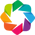

:Spikes   [date]

In [31]:
%%opts Spikes [spike_length=500] NdOverlay [show_legend=False]
hv.notebook_extension('bokeh')
spikes = hv.Spikes(events.index, kdims=[('date','Date')])
spikes * hv.Points([(20,.4),(60,10)])
spikes
#events.dtypes

In [65]:
(np.datetime64('2017-10-13T04:52:15.285047')-np.datetime64('2017-10-13T03:19:45.411797')).astype('timedelta64[m]').astype(int)<12*60*60

True

In [10]:
points = hv.Points(np.random.randn(500,2)).hist(num_bins=51, dimension=['x','y'])
#points.hist(num_bins=51, dimension=['x','y'])
points

:AdjointLayout
   :Histogram   [y]   (y_frequency)
   :Points   [x,y]
   :Histogram   [x]   (x_frequency)

In [8]:
np.timedelta64(6,'h')

numpy.timedelta64(6,'h')

In [85]:
for val in categorical:
        if val in df.columns:
            print (val)
            df[val] =df[val].cat.add_categories("None")
        else: df[val] = np.nan

EventType
Message
CID
DeviceMode
DeviceState
Frequency
IP_Address
Interface
MCC_MNC
Operator
Host


In [80]:
df.Message.unique()
#df.columns

[NaN, Failed Backend reachable via autotunnel, 22/23 tests succeeded, 23 tests run., Resolving to Reinstall if no connection in thr..., 23/23 tests succeeded, 23 tests run.]
Categories (4, object): [Failed Backend reachable via autotunnel, 22/23 tests succeeded, 23 tests run., Resolving to Reinstall if no connection in thr..., 23/23 tests succeeded, 23 tests run.]

In [110]:
rtt_opts

{'Points': {'plot': {'color_index': 'Message',
   'colorbar': True,
   'height': 400,
   'tools': ['hover'],
   'width': 1400},
  'style': {'cmap': 'tab10', 'size': 3}}}

In [4]:
rtt_opts.get('Points').get('plot').get('color_index')

'Message'

In [8]:
rtt_opts['Points']['plot']['color_index']='Cid'

In [9]:
rtt_opts

{'Points': {'plot': {'color_index': 'Cid',
   'colorbar': True,
   'height': 400,
   'tools': ['hover'],
   'width': 1400},
  'style': {'cmap': 'tab10', 'size': 3}}}

In [35]:
import bokeh
hv.palettes.__palettes__

AttributeError: module 'holoviews' has no attribute 'palettes'

In [49]:
spike_times = np.random.randint(0, 10000, size=(1000))
clusters = np.random.randint(0, 5, size=1000)

ds = hv.Dataset((spike_times, clusters), kdims=['Spike Times', 'Clusters'])



In [52]:
%%opts Spikes (color=hv.Palette('Set1')) NdOverlay [legend_position='right' toolbar='below' width=800]
overlay = ds.to(hv.Spikes, 'Spike Times').overlay()
overlay

:NdOverlay   [Clusters]
   :Spikes   [Spike Times]

In [121]:
events = pd.DataFrame(columns=['Date','EventType'])
events['Date'] = pd.to_datetime(events.Date)
events['EventType'] = events['EventType'].astype('category')
events['EventType'] = events['EventType'].cat.add_categories('Scheduling.Task.Started')
events['EventType'] = events['EventType'].cat.add_categories('Scheduling.Task.Stopped')
events['EventType'] = events['EventType'].cat.add_categories('Scheduling.Task.Deploying')
events['EventType'] = events['EventType'].cat.add_categories('Scheduling.Task.Deployed')


center = (explorer.range_stream.x_range[1]-explorer.range_stream.x_range[0])/2+explorer.range_stream.x_range[0]
events = events.append({'Date':center, 'EventType':'Scheduling.Task.Started'}, ignore_index=True)
events = events.append({'Date':center, 'EventType':'Scheduling.Task.Stopped'}, ignore_index=True)
events = events.append({'Date':center, 'EventType':'Scheduling.Task.Deploying'}, ignore_index=True)
events = events.append({'Date':center, 'EventType':'Scheduling.Task.Deployed'}, ignore_index=True)
events

Date                  EventType
0 2017-10-13 13:19:12.230274    Scheduling.Task.Started
1 2017-10-13 13:19:12.230274    Scheduling.Task.Stopped
2 2017-10-13 13:19:12.230274  Scheduling.Task.Deploying
3 2017-10-13 13:19:12.230274   Scheduling.Task.Deployed

In [90]:
events

Empty DataFrame
Columns: [Date, EventType]
Index: []

In [6]:
np.datetime64('2010-10-17 07:15:30')

numpy.datetime64('2010-10-17T07:15:30')

In [13]:
hv.__version__

1.9.2

In [53]:
hv.Palette(spikes_colors)

ValueError: String 'key' only takes a string value.

In [59]:
spike_opts

{'Spikes': {'style': {'color': Palette(values=['#8dd3c7', '#8dd3c7', '#8dd3c7', '#ffffb3', '#ffffb3', '#ffffb3', '#bebada', '#bebada', '#bebada', '#fb8072', '#fb8072', '#fb8072', '#80b1d3', '#80b1d3', '#80b1d3', '#fdb462', '#fdb462', '#b3de69', '#b3de69', '#b3de69', '#fccde5', '#fccde5', '#fccde5', '#d9d9d9', '#d9d9d9', '#d9d9d9', '#bc80bd', '#bc80bd', '#bc80bd', '#ccebc5', '#ccebc5', '#ffed6f']),
   'line_width': 2}}}

In [ ]:
'plot':dict(spike_length=df.RTT.max()), 

In [64]:
spike_opts['Spikes']={'plot':dict(spike_length=df.RTT.max())}

NameError: name 'df' is not defined

In [69]:
spike_opts['Spikes']['plot']=dict(spike_length=100)

In [70]:
spike_opts

{'Spikes': {'plot': {'spike_length': 100},
  'style': {'color': Palette(values=['#8dd3c7', '#8dd3c7', '#8dd3c7', '#ffffb3', '#ffffb3', '#ffffb3', '#bebada', '#bebada', '#bebada', '#fb8072', '#fb8072', '#fb8072', '#80b1d3', '#80b1d3', '#80b1d3', '#fdb462', '#fdb462', '#b3de69', '#b3de69', '#b3de69', '#fccde5', '#fccde5', '#fccde5', '#d9d9d9', '#d9d9d9', '#d9d9d9', '#bc80bd', '#bc80bd', '#bc80bd', '#ccebc5', '#ccebc5', '#ffed6f']),
   'line_width': 2}}}

In [130]:
ds = hv.Dataset((events.Date, events.EventType), kdims=['Date', 'EventType'])
overlay = ds.to(hv.Spikes)#.overlay().opts(spike_opts)

In [140]:
overlay.items()

[('Scheduling.Task.Deployed', :Spikes   [Date]),
 ('Scheduling.Task.Deploying', :Spikes   [Date])]

In [56]:
cm

OrderedDict([('cyclic_grey_15_85_c0',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a4668e438>),
             ('cyclic_grey_15_85_c0_r',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a46695048>),
             ('cyclic_grey_15_85_c0_s25',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a46695d68>),
             ('cyclic_grey_15_85_c0_s25_r',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a46650048>),
             ('cyclic_mrybm_35_75_c68',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a466506d8>),
             ('cyclic_mrybm_35_75_c68_r',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a46608048>),
             ('cyclic_mrybm_35_75_c68_s25',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a465bc048>),
             ('cyclic_mrybm_35_75_c68_s25_r',
              <matplotlib.colors.LinearSegmentedColormap at 0x7f0a465c0048>),
             ('cyclic_mygbm_30_95_c78',


In [33]:
import pytz
import datetime
cet = pytz.timezone('CET')
import numpy as np
delta = np.timedelta64(cet.utcoffset(datetime.datetime.now()))

In [34]:


#import time
#time.timezone
delta

numpy.timedelta64(3600000000,'us')

In [53]:
datetime.datetime.now()

NameError: name 'datetime' is not defined

In [69]:
import bokeh as bk
bk.palettes.

<module 'bokeh.palettes'>

In [70]:
cm['m_fire_r']

KeyError: 'm_fire_r'

In [67]:
from bokeh.core.enums import Palette

In [75]:
import colorcet as cc
cc.m_fire

In [85]:
cm.keys()

odict_keys(['cyclic_grey_15_85_c0', 'cyclic_grey_15_85_c0_r', 'cyclic_grey_15_85_c0_s25', 'cyclic_grey_15_85_c0_s25_r', 'cyclic_mrybm_35_75_c68', 'cyclic_mrybm_35_75_c68_r', 'cyclic_mrybm_35_75_c68_s25', 'cyclic_mrybm_35_75_c68_s25_r', 'cyclic_mygbm_30_95_c78', 'cyclic_mygbm_30_95_c78_r', 'cyclic_mygbm_30_95_c78_s25', 'cyclic_mygbm_30_95_c78_s25_r', 'colorwheel', 'colorwheel_r', 'cyclic_wrwbw_40_90_c42', 'cyclic_wrwbw_40_90_c42_r', 'cyclic_wrwbw_40_90_c42_s25', 'cyclic_wrwbw_40_90_c42_s25_r', 'diverging_isoluminant_cjm_75_c23', 'diverging_isoluminant_cjm_75_c23_r', 'diverging_isoluminant_cjm_75_c24', 'diverging_isoluminant_cjm_75_c24_r', 'diverging_isoluminant_cjo_70_c25', 'diverging_isoluminant_cjo_70_c25_r', 'diverging_linear_bjr_30_55_c53', 'diverging_linear_bjr_30_55_c53_r', 'diverging_linear_bjy_30_90_c45', 'diverging_linear_bjy_30_90_c45_r', 'bjy', 'bjy_r', 'diverging_rainbow_bgymr_45_85_c67', 'diverging_rainbow_bgymr_45_85_c67_r', 'diverging_bkr_55_10_c35', 'diverging_bkr_55_10_

In [92]:
import ipywidgets as widgets


widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

In [16]:
df = getdf('ping', nodeid=372)

In [39]:
df['RTT'].max()

310.4238095238095

In [70]:
#time.utcoffset
pytz.timezone(None)

AttributeError: 'NoneType' object has no attribute 'upper'

In [64]:
np.datetime64('2000-01-01T00:00:00-08')

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


numpy.datetime64('2000-01-01T08:00:00')

In [122]:
import dateutil
localtz = dateutil.tz.tzlocal()
localtz.tzname(datetime.datetime.now(localtz))

'CET'

In [148]:
localtz.utcoffset(datetime.datetime.now())

datetime.timedelta(0, 3600)

In [149]:
pytz.timezone(constants.TIME_ZONE)

NameError: name 'constants' is not defined

In [150]:
gmtime()

NameError: name 'gmtime' is not defined

In [151]:
localtime()

NameError: name 'localtime' is not defined

In [176]:
import time

print (-time.timezone)

3600


In [177]:
time.localtime().tm_gmtoff

3600

In [178]:
import time
from datetime import datetime

ts = time.time()
utc_offset = (datetime.fromtimestamp(ts) -
              datetime.utcfromtimestamp(ts)).total_seconds()

In [18]:
TZ

'CET'

In [20]:
import pytz
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [48]:
table_timerange('event', nodeid='7')

NameError: name 'table_timerange' is not defined

In [36]:
import pytz
import datetime as dt
cet = pytz.timezone('CET')
np.timedelta64(cet.utcoffset(dt.datetime.now()))

numpy.timedelta64(3600000000,'us')

In [113]:
from monroe_anal import query

result = query("SELECT * FROM ping_30m WHERE NodeId='59' and Operator = 'Orange' LIMIT 100")
list(result.get_points())

[{'Host': '193.10.227.25',
  'Iccid': '8934014251541036021',
  'NodeId': '59',
  'Operator': 'Orange',
  'RTT': 110.30707964601764,
  'time': 1501545600000},
 {'Host': '193.10.227.25',
  'Iccid': '8934014251541036021',
  'NodeId': '59',
  'Operator': 'Orange',
  'RTT': 110.55257611241223,
  'time': 1501547400000},
 {'Host': '193.10.227.25',
  'Iccid': '8934014251541036021',
  'NodeId': '59',
  'Operator': 'Orange',
  'RTT': 111.45036572622782,
  'time': 1501549200000},
 {'Host': '193.10.227.25',
  'Iccid': '8934014251541036021',
  'NodeId': '59',
  'Operator': 'Orange',
  'RTT': 114.48179384203488,
  'time': 1501551000000},
 {'Host': '193.10.227.25',
  'Iccid': '8934014251541036021',
  'NodeId': '59',
  'Operator': 'Orange',
  'RTT': 117.29845360824743,
  'time': 1501552800000},
 {'Host': '193.10.227.25',
  'Iccid': '8934014251541036021',
  'NodeId': '59',
  'Operator': 'Orange',
  'RTT': 113.90310478654584,
  'time': 1501554600000},
 {'Host': '193.10.227.25',
  'Iccid': '8934014251541

In [210]:
rs = query("SELECT * FROM ping_30m WHERE NodeId='59' limit 10")
#ist(result.get_points())
points = list(rs.get_points(measurement='ping_30m'))
rs

#tags={'Iccid': '8934014251541036021'}

ResultSet({'('ping_30m', None)': [{'Iccid': '8934014251541036021', 'Operator': 'Orange', 'NodeId': '59', 'time': 1501545600000, 'Host': '193.10.227.25', 'RTT': 110.30707964601764}, {'Iccid': '8939104120002605386', 'Operator': 'voda ES', 'NodeId': '59', 'time': 1501545600000, 'Host': '193.10.227.25', 'RTT': 88.3838815789474}, {'Iccid': '8934041514050773889', 'Operator': 'YOIGO', 'NodeId': '59', 'time': 1501545600000, 'Host': '193.10.227.25', 'RTT': 119.36438356164383}, {'Iccid': '8939104120002605386', 'Operator': 'voda ES', 'NodeId': '59', 'time': 1501547400000, 'Host': '193.10.227.25', 'RTT': 88.34752104770827}, {'Iccid': '8934041514050773889', 'Operator': 'YOIGO', 'NodeId': '59', 'time': 1501547400000, 'Host': '193.10.227.25', 'RTT': 118.02679282868526}, {'Iccid': '8934014251541036021', 'Operator': 'Orange', 'NodeId': '59', 'time': 1501547400000, 'Host': '193.10.227.25', 'RTT': 110.55257611241223}, {'Iccid': '8934041514050773889', 'Operator': 'YOIGO', 'NodeId': '59', 'time': 150154920

In [199]:
query("SHOW TAG VALUES FROM ping_30m WITH KEY = NodeId")

ResultSet({'('ping_30m', None)': [{'key': 'NodeId', 'value': '103'}, {'key': 'NodeId', 'value': '111'}, {'key': 'NodeId', 'value': '119'}, {'key': 'NodeId', 'value': '126'}, {'key': 'NodeId', 'value': '127'}, {'key': 'NodeId', 'value': '133'}, {'key': 'NodeId', 'value': '135'}, {'key': 'NodeId', 'value': '144'}, {'key': 'NodeId', 'value': '145'}, {'key': 'NodeId', 'value': '146'}, {'key': 'NodeId', 'value': '148'}, {'key': 'NodeId', 'value': '149'}, {'key': 'NodeId', 'value': '150'}, {'key': 'NodeId', 'value': '151'}, {'key': 'NodeId', 'value': '152'}, {'key': 'NodeId', 'value': '171'}, {'key': 'NodeId', 'value': '175'}, {'key': 'NodeId', 'value': '186'}, {'key': 'NodeId', 'value': '187'}, {'key': 'NodeId', 'value': '193'}, {'key': 'NodeId', 'value': '195'}, {'key': 'NodeId', 'value': '196'}, {'key': 'NodeId', 'value': '197'}, {'key': 'NodeId', 'value': '198'}, {'key': 'NodeId', 'value': '203'}, {'key': 'NodeId', 'value': '206'}, {'key': 'NodeId', 'value': '211'}, {'key': 'NodeId', 'va

In [163]:
(query("show tag keys"))

ResultSet({'('event_10ms', None)': [{'tagKey': 'NodeId'}], '('event_1m', None)': [{'tagKey': 'NodeId'}], '('event_1s', None)': [{'tagKey': 'NodeId'}], '('event_30m', None)': [{'tagKey': 'NodeId'}], '('gps_10ms', None)': [{'tagKey': 'NodeId'}], '('gps_1m', None)': [{'tagKey': 'NodeId'}], '('gps_1s', None)': [{'tagKey': 'NodeId'}], '('gps_30m', None)': [{'tagKey': 'NodeId'}], '('modem_10ms', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('modem_1m', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('modem_1s', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('modem_30m', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('ping_10ms', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('ping_1m', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('ping_1s', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('ping_30m', None)': [{'tagKey': 'Iccid'}, {'tagKey': 'NodeId'}], '('sensor_10ms', None)': [{'tagKey': 'NodeId'}], '('sensor_1m', None)': [{'tagKey': '

In [171]:
#query("show tag values with key = NodeId")
query("select distinct(NodeId) from ping_30m")

ResultSet({})